# Vision Transformer Comparison on CIFAR-10

Notebook ini membandingkan Swin Transformer dan Data-efficient Image Transformer (DeiT) pada CIFAR-10 menggunakan transfer learning.


## Tujuan Eksperimen
- Memuat CIFAR-10 (PyTorch) serta melakukan visualisasi contoh per kelas dan distribusi kelas.
- Melatih dan mengevaluasi Swin Transformer serta DeiT yang dipra-latih (transfer learning) dengan pipeline yang seragam.
- Menganalisis jumlah parameter, ukuran model, dan kinerja (akurasi, precision, recall, F1 per kelas dan rata-rata, confusion matrix, kurva loss & accuracy).
- Mengukur performa inferensi (warm-up, >=100 gambar, rata-rata & deviasi standar per gambar, total waktu test set, throughput, serta deskripsi hardware).

> **Catatan:** Pastikan tidak ada proses berat lain yang berjalan saat menjalankan sel pengukuran inferensi demi hasil waktu yang konsisten.


## 1. Instalasi Dependensi


In [2]:
# Langkah 1 - Instalasi dependensi eksternal yang digunakan di seluruh notebook
!pip install -q timm seaborn scikit-learn psutil


## 2. Import Library & Setup Visualisasi


In [3]:
# Langkah 2 - Import library inti serta utilitas visualisasi
import os
import time
import json
import math
import copy
import random
import platform
from itertools import cycle
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import timm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import psutil

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Penyetelan gaya visual agar konsisten di seluruh plot
plt.style.use("seaborn-v0_8")
sns.set_palette("deep")


## 3. Konfigurasi Eksperimen & Model


In [4]:
# Langkah 3 - Konfigurasi hyperparameter global dan daftar model yang dievaluasi
CONFIG = {
    "seed": 42,
    "data_dir": "data",
    "image_size": 224,
    "batch_size": 128,
    "val_split": 0.1,
    "num_workers": 4,
    "num_epochs": 5,
    "learning_rate": 5e-5,
    "weight_decay": 1e-4,
    "warmup_batches": 5,
    "inference_images": 512,
}

# Definisi backbone yang diuji beserta nama alias yang ramah dibaca
MODEL_SPECS = {
    "swin_tiny_patch4_window7_224": {"alias": "Swin Transformer (Tiny)"},
    "deit_tiny_patch16_224": {"alias": "DeiT Tiny"},
}

# Label default CIFAR-10 agar mudah dirujuk di visualisasi
CLASS_NAMES = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


## 4. Utility Seed & Hardware


In [5]:
# Langkah 4 - Utility untuk reproduktibilitas dan informasi hardware

def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def get_device() -> torch.device:
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_hardware_info(device: torch.device) -> dict:
    info = {
        "device": str(device),
        "cuda_name": None,
        "cuda_total_mem_gb": None,
        "cpu": platform.processor(),
        "num_cpu_cores": os.cpu_count(),
        "ram_gb": round(psutil.virtual_memory().total / (1024 ** 3), 2) if psutil else None,
    }
    if device.type == "cuda":
        info["cuda_name"] = torch.cuda.get_device_name(0)
        total_mem = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)
        info["cuda_total_mem_gb"] = round(total_mem, 2)
    return info


# Inisialisasi lingkungan serta tampilkan detail perangkat keras yang digunakan
set_seed(CONFIG["seed"])
device = get_device()
hardware_info = get_hardware_info(device)
print("Menggunakan device:", hardware_info["device"], hardware_info.get("cuda_name", "CPU"))
display(pd.DataFrame([hardware_info]))


Menggunakan device: cuda Tesla T4


,device,cuda_name,cuda_total_mem_gb,cpu,num_cpu_cores,ram_gb
0,cuda,Tesla T4,14.74,x86_64,2,12.67


## 5. Load Dataset CIFAR-10 & DataLoader


In [6]:
# Langkah 5 - Load dataset CIFAR-10, lakukan augmentasi, dan siapkan DataLoader
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

# Augmentasi dasar untuk data latih, sedangkan validasi/test memakai normalisasi saja
train_transforms = transforms.Compose([
    transforms.Resize(CONFIG["image_size"]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(CONFIG["image_size"], padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

eval_transforms = transforms.Compose([
    transforms.Resize(CONFIG["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

display_transforms = transforms.Compose([
    transforms.Resize(CONFIG["image_size"]),
    transforms.ToTensor(),
])

# Unduh dataset dan siapkan tiga versi transform untuk train/val/test/visualisasi
data_dir = Path(CONFIG["data_dir"])
data_dir.mkdir(parents=True, exist_ok=True)

train_base_aug = datasets.CIFAR10(root=str(data_dir), train=True, transform=train_transforms, download=True)
train_base_eval = datasets.CIFAR10(root=str(data_dir), train=True, transform=eval_transforms, download=False)
vis_dataset = datasets.CIFAR10(root=str(data_dir), train=True, transform=display_transforms, download=False)

# Split train menjadi train/val menggunakan shuffle reproducible
total_samples = len(train_base_aug)
indices = np.arange(total_samples)
np.random.default_rng(CONFIG["seed"]).shuffle(indices)
val_size = int(total_samples * CONFIG["val_split"])
val_indices = indices[:val_size]
train_indices = indices[val_size:]

train_dataset = Subset(train_base_aug, train_indices)
val_dataset = Subset(train_base_eval, val_indices)
test_dataset = datasets.CIFAR10(root=str(data_dir), train=False, transform=eval_transforms, download=True)

CLASS_NAMES = train_base_aug.classes

# DataLoader dengan pin_memory saat GPU tersedia untuk throughput maksimal
pin_memory = device.type == "cuda"
train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"], pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"], pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"], pin_memory=pin_memory)

# Statistik distribusi kelas untuk visualisasi
class_counts = np.bincount(train_base_aug.targets, minlength=len(CLASS_NAMES))
print(f"Train/Val/Test samples: {len(train_dataset)}/{len(val_dataset)}/{len(test_dataset)}")


100%|██████████| 170M/170M [00:14<00:00, 11.5MB/s]


Train/Val/Test samples: 45000/5000/10000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 6. Visualisasi CIFAR-10


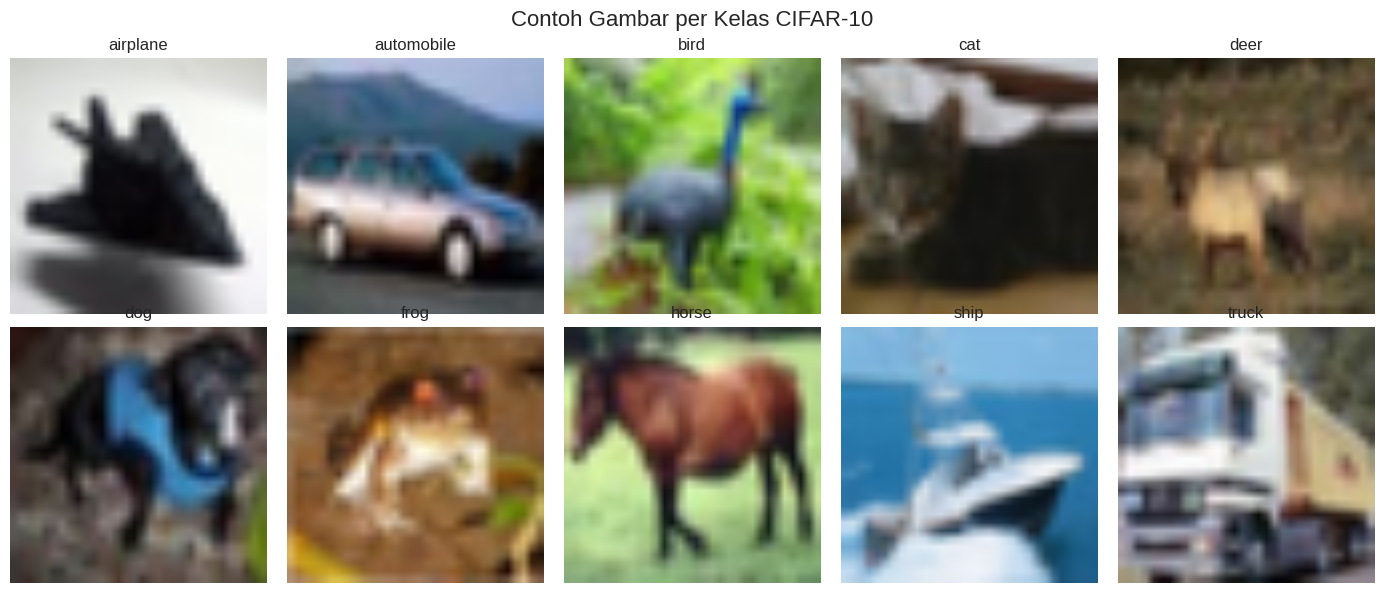

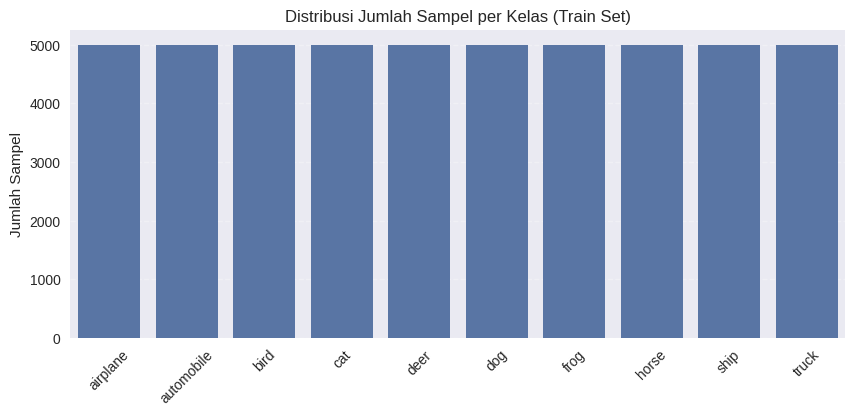

In [7]:
# Langkah 6 - Visualisasi contoh per kelas dan distribusi jumlah data
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
samples_per_class = {}
for img, label in vis_dataset:
    class_name = CLASS_NAMES[label]
    if class_name not in samples_per_class:
        samples_per_class[class_name] = img
    if len(samples_per_class) == len(CLASS_NAMES):
        break

for ax, class_name in zip(axes.flatten(), CLASS_NAMES):
    sample = samples_per_class[class_name]
    ax.imshow(sample.permute(1, 2, 0))
    ax.set_title(class_name)
    ax.axis("off")

plt.suptitle("Contoh Gambar per Kelas CIFAR-10", fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(x=CLASS_NAMES, y=class_counts)
plt.title("Distribusi Jumlah Sampel per Kelas (Train Set)")
plt.ylabel("Jumlah Sampel")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


## 7. Utility Model (Build & Profiling)


In [8]:
# Langkah 7 - Utility model untuk membangun backbone TIMM dan memprofil parameternya

def build_model(model_name: str, num_classes: int) -> nn.Module:
    model = timm.create_model(model_name, pretrained=True)
    model.reset_classifier(num_classes)  # Ganti head agar cocok dengan CIFAR-10
    return model


def profile_model(model: nn.Module) -> dict:
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    model_size_mb = round(total_params * 4 / (1024 ** 2), 2)  # Asumsi float32
    return {
        "total_params": total_params,
        "trainable_params": trainable_params,
        "non_trainable_params": non_trainable_params,
        "model_size_mb": model_size_mb,
    }


## 8. Fungsi Training


In [9]:
# Langkah 8 - Fungsi training standar dengan pelacakan metrik

def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                criterion: nn.Module,
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler._LRScheduler | None,
                device: torch.device,
                num_epochs: int) -> tuple[dict, dict]:
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }
    best_state = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        # ---- Training phase ----
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()
            total += inputs.size(0)

        train_loss = running_loss / total
        train_acc = running_corrects / total

        # ---- Validation phase ----
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = outputs.argmax(dim=1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += (preds == labels).sum().item()
                val_total += inputs.size(0)

        val_loss /= val_total
        val_acc = val_corrects / val_total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if scheduler is not None:
            scheduler.step()

        # Simpan bobot terbaik berdasarkan akurasi validasi
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch:02d}/{num_epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    return history, best_state


## 9. Evaluasi, Plotting, & Benchmark Inferensi


In [10]:
# Langkah 9 - Fungsi evaluasi rinci, plotting kurva, dan benchmark inferensi

def evaluate_model(model: nn.Module,
                   dataloader: DataLoader,
                   device: torch.device,
                   class_names: list[str]) -> dict:
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(len(class_names))), zero_division=0
    )
    overall_accuracy = (y_true == y_pred).mean()
    macro_precision = precision.mean()
    macro_recall = recall.mean()
    macro_f1 = f1.mean()

    per_class_df = pd.DataFrame({
        "class": class_names,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "support": support,
    })
    per_class_df.loc["macro_avg"] = ["macro_avg", macro_precision, macro_recall, macro_f1, support.sum()]

    return {
        "overall_accuracy": overall_accuracy,
        "precision_per_class": precision,
        "recall_per_class": recall,
        "f1_per_class": f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
        "confusion_matrix": cm,
        "classification_report": per_class_df,
        "y_true": y_true,
        "y_pred": y_pred,
    }


def plot_training_curves(history: dict, title: str) -> None:
    epochs = range(1, len(history["train_loss"]) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(epochs, history["train_loss"], label="Train")
    axes[0].plot(epochs, history["val_loss"], label="Val")
    axes[0].set_title(f"{title} - Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Cross-Entropy Loss")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(epochs, history["train_acc"], label="Train")
    axes[1].plot(epochs, history["val_acc"], label="Val")
    axes[1].set_title(f"{title} - Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm: np.ndarray, class_names: list[str], title: str) -> None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


def benchmark_inference(model: nn.Module,
                        dataloader: DataLoader,
                        device: torch.device,
                        warmup_batches: int,
                        target_images: int) -> dict:
    model.eval()
    iterator = cycle(dataloader)
    timings = []
    measured = 0

    with torch.no_grad():
        # Warm-up: jalankan beberapa batch awal tanpa diukur untuk menstabilkan performa
        for _ in range(warmup_batches):
            inputs, _ = next(iterator)
            inputs = inputs.to(device, non_blocking=True)
            _ = model(inputs)
            if device.type == "cuda":
                torch.cuda.synchronize()

        # Pengukuran inference minimal 100 gambar
        while measured < target_images:
            inputs, _ = next(iterator)
            inputs = inputs.to(device, non_blocking=True)
            start = time.perf_counter()
            _ = model(inputs)
            if device.type == "cuda":
                torch.cuda.synchronize()
            end = time.perf_counter()
            batch_time = end - start
            per_image = batch_time / inputs.size(0)
            timings.append(per_image)
            measured += inputs.size(0)

    timings = np.array(timings)
    mean_per_image_ms = timings.mean() * 1000
    std_per_image_ms = timings.std(ddof=1) * 1000 if len(timings) > 1 else 0.0
    test_set_time = (mean_per_image_ms / 1000) * len(dataloader.dataset)
    throughput = 1.0 / timings.mean()

    return {
        "images_measured": measured,
        "mean_ms_per_image": mean_per_image_ms,
        "std_ms_per_image": std_per_image_ms,
        "estimated_test_time_s": test_set_time,
        "throughput_img_per_s": throughput,
        "warmup_batches": warmup_batches,
    }


## 10. Eksekusi Eksperimen Swin vs DeiT


In [18]:
# Langkah 10 - Eksekusi eksperimen transfer learning Swin Transformer vs DeiT
criterion = nn.CrossEntropyLoss()
experiment_results = {}

target_inference_images = max(CONFIG["inference_images"], 100)

for model_name, spec in MODEL_SPECS.items():
    alias = spec["alias"]
    print("" + "=" * 90)
    print(f"Model: {alias} ({model_name})")
    print("=" * 90)

    # Bangun model pra-latih dan siapkan optimizer + scheduler
    model = build_model(model_name, num_classes=len(CLASS_NAMES)).to(device)
    profile = profile_model(model)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG["num_epochs"])

    # Training + validasi untuk beberapa epoch
    history, best_state = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=CONFIG["num_epochs"],
    )

    # Load the best state dictionary before evaluation and inference
    model.load_state_dict(best_state)

    # Evaluasi metrik klasifikasi dan benchmark inferensi
    eval_metrics = evaluate_model(model, test_loader, device, CLASS_NAMES)
    inference_metrics = benchmark_inference(
        model,
        test_loader,
        device,
        warmup_batches=CONFIG["warmup_batches"],
        target_images=target_inference_images,
    )

    experiment_results[alias] = {
        "model_name": model_name,
        "profile": profile,
        "history": history,
        "evaluation": eval_metrics,
        "inference": inference_metrics,
        "hardware": hardware_info,
        "best_state": best_state, # Store the best state here
    }

    print(f"Test Accuracy: {eval_metrics['overall_accuracy']:.4f}")
    print(f"Macro Precision/Recall/F1: {eval_metrics['macro_precision']:.4f} / {eval_metrics['macro_recall']:.4f} / {eval_metrics['macro_f1']:.4f}")
    print(
        "Avg Inference: "
        f"{inference_metrics['mean_ms_per_image']:.2f} \u00b1 {inference_metrics['std_ms_per_image']:.2f} ms/img "
        f"(Throughput: {inference_metrics['throughput_img_per_s']:.2f} img/s)"
    )

Model: Swin Transformer (Tiny) (swin_tiny_patch4_window7_224)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 01/5 | Train Loss: 0.2846 Acc: 0.9100 | Val Loss: 0.1123 Acc: 0.9628
Epoch 02/5 | Train Loss: 0.0925 Acc: 0.9700 | Val Loss: 0.1064 Acc: 0.9646
Epoch 03/5 | Train Loss: 0.0533 Acc: 0.9827 | Val Loss: 0.0864 Acc: 0.9726
Epoch 04/5 | Train Loss: 0.0324 Acc: 0.9901 | Val Loss: 0.0860 Acc: 0.9744
Epoch 05/5 | Train Loss: 0.0196 Acc: 0.9949 | Val Loss: 0.0786 Acc: 0.9774


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 0.9773
Macro Precision/Recall/F1: 0.9773 / 0.9773 / 0.9773
Avg Inference: 4.51 ± 0.05 ms/img (Throughput: 221.55 img/s)
Model: DeiT Tiny (deit_tiny_patch16_224)
Epoch 01/5 | Train Loss: 0.3504 Acc: 0.8842 | Val Loss: 0.1805 Acc: 0.9396
Epoch 02/5 | Train Loss: 0.1251 Acc: 0.9576 | Val Loss: 0.1488 Acc: 0.9516
Epoch 03/5 | Train Loss: 0.0754 Acc: 0.9755 | Val Loss: 0.1248 Acc: 0.9554
Epoch 04/5 | Train Loss: 0.0407 Acc: 0.9874 | Val Loss: 0.1194 Acc: 0.9638
Epoch 05/5 | Train Loss: 0.0256 Acc: 0.9928 | Val Loss: 0.1131 Acc: 0.9624


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 0.9598
Macro Precision/Recall/F1: 0.9598 / 0.9598 / 0.9597
Avg Inference: 1.07 ± 0.05 ms/img (Throughput: 931.73 img/s)


## 11. Visualisasi Hasil per Model


--------------------------------------------------------------------------------
Swin Transformer (Tiny)
--------------------------------------------------------------------------------


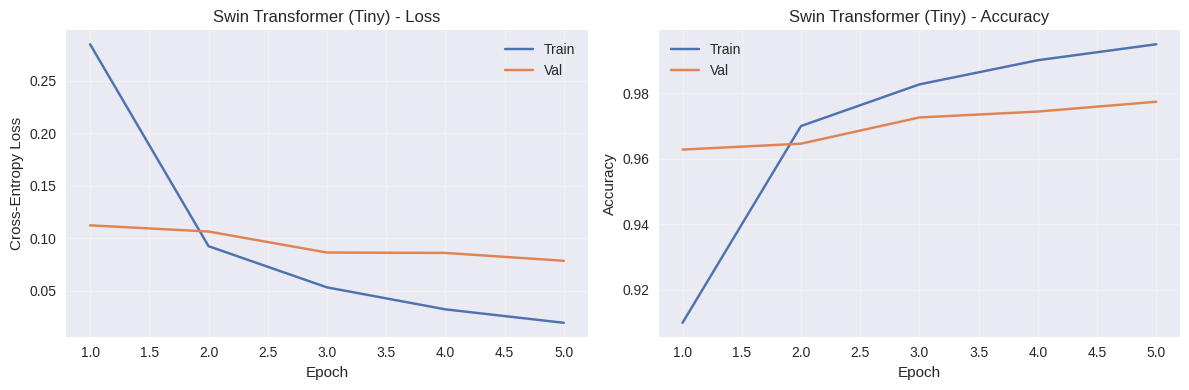

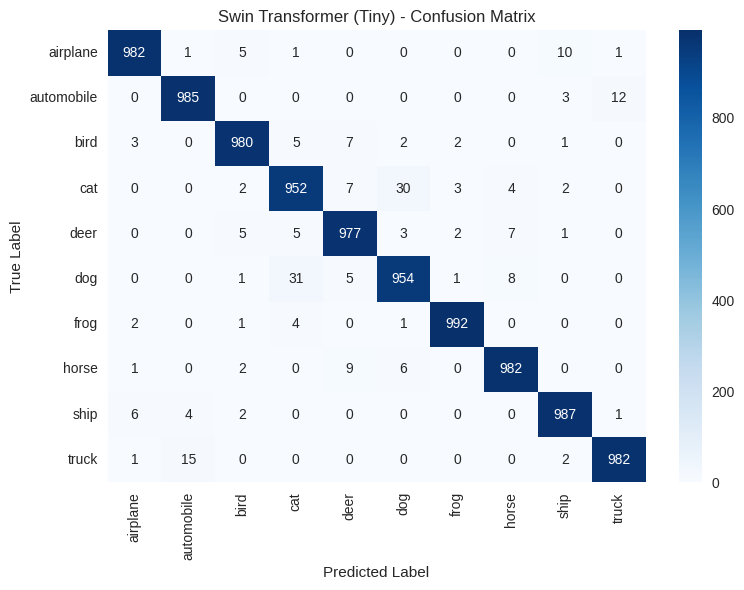

,class,precision,recall,f1,support
0,airplane,0.986935,0.9820,0.984461,1000
1,automobile,0.980100,0.9850,0.982544,1000
2,bird,0.981964,0.9800,0.980981,1000
3,cat,0.953908,0.9520,0.952953,1000
4,deer,0.972139,0.9770,0.974564,1000
5,dog,0.957831,0.9540,0.955912,1000
6,frog,0.992000,0.9920,0.992000,1000
7,horse,0.981019,0.9820,0.981509,1000
8,ship,0.981113,0.9870,0.984048,1000
9,truck,0.985944,0.9820,0.983968,1000


--------------------------------------------------------------------------------
DeiT Tiny
--------------------------------------------------------------------------------


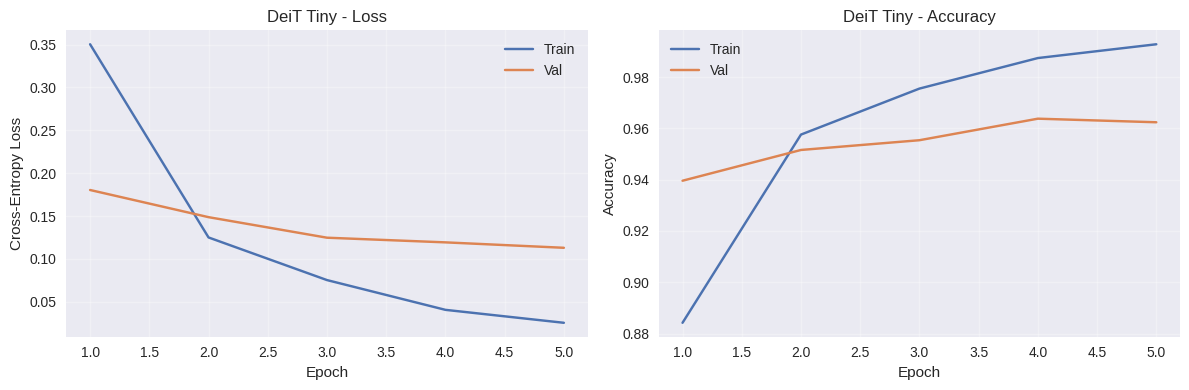

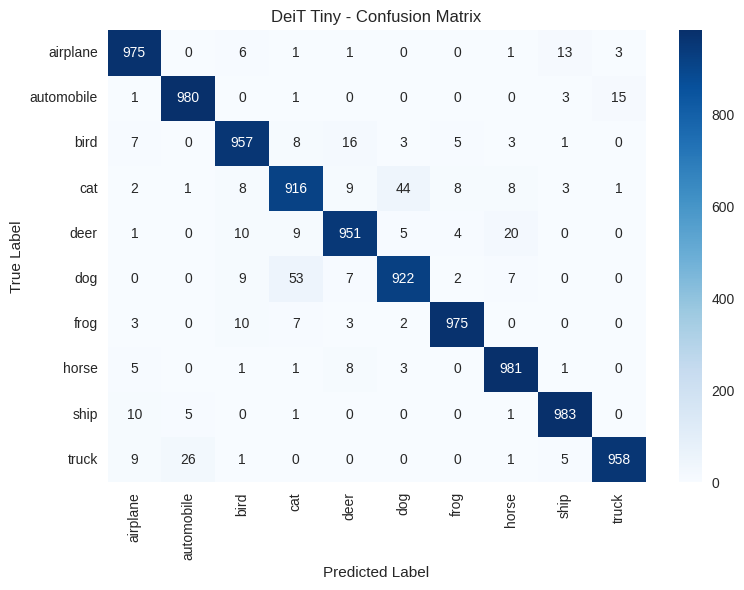

,class,precision,recall,f1,support
0,airplane,0.962488,0.9750,0.968703,1000
1,automobile,0.968379,0.9800,0.974155,1000
2,bird,0.955090,0.9570,0.956044,1000
3,cat,0.918756,0.9160,0.917376,1000
4,deer,0.955779,0.9510,0.953383,1000
5,dog,0.941777,0.9220,0.931784,1000
6,frog,0.980885,0.9750,0.977934,1000
7,horse,0.959883,0.9810,0.970326,1000
8,ship,0.974232,0.9830,0.978596,1000
9,truck,0.980553,0.9580,0.969145,1000


In [19]:
# Langkah 11 - Visualisasi kurva belajar, confusion matrix, dan laporan klasifikasi
for alias, result in experiment_results.items():
    print("" + "-" * 80)
    print(alias)
    print("-" * 80)
    plot_training_curves(result["history"], alias)
    plot_confusion_matrix(result["evaluation"]["confusion_matrix"], CLASS_NAMES, f"{alias} - Confusion Matrix")
    display(result["evaluation"]["classification_report"])


Contoh prediksi untuk Swin Transformer (Tiny)


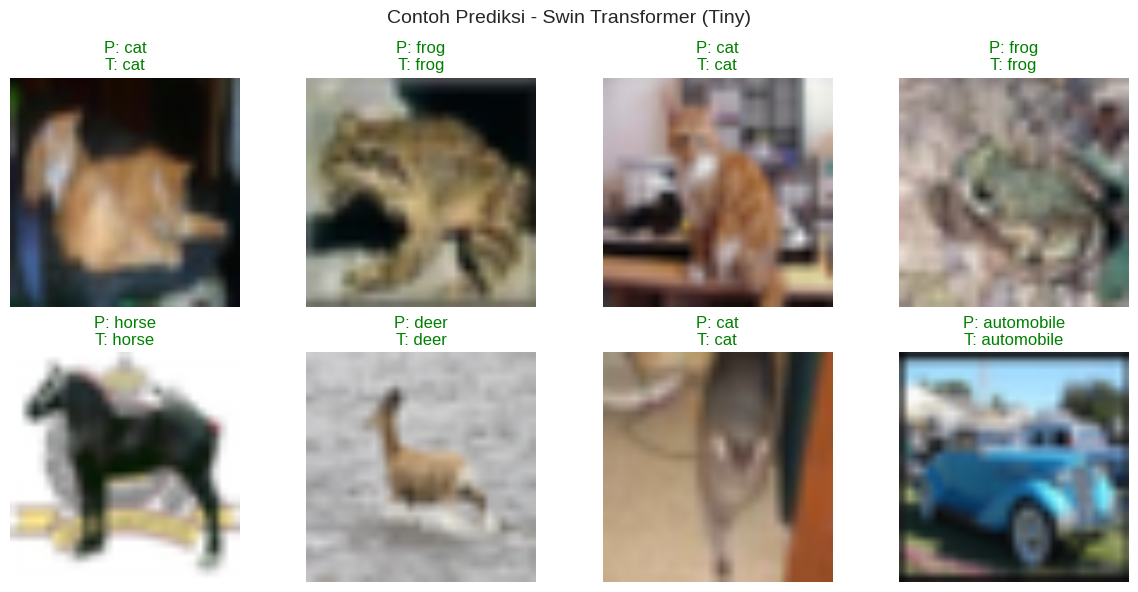

Contoh prediksi untuk DeiT Tiny


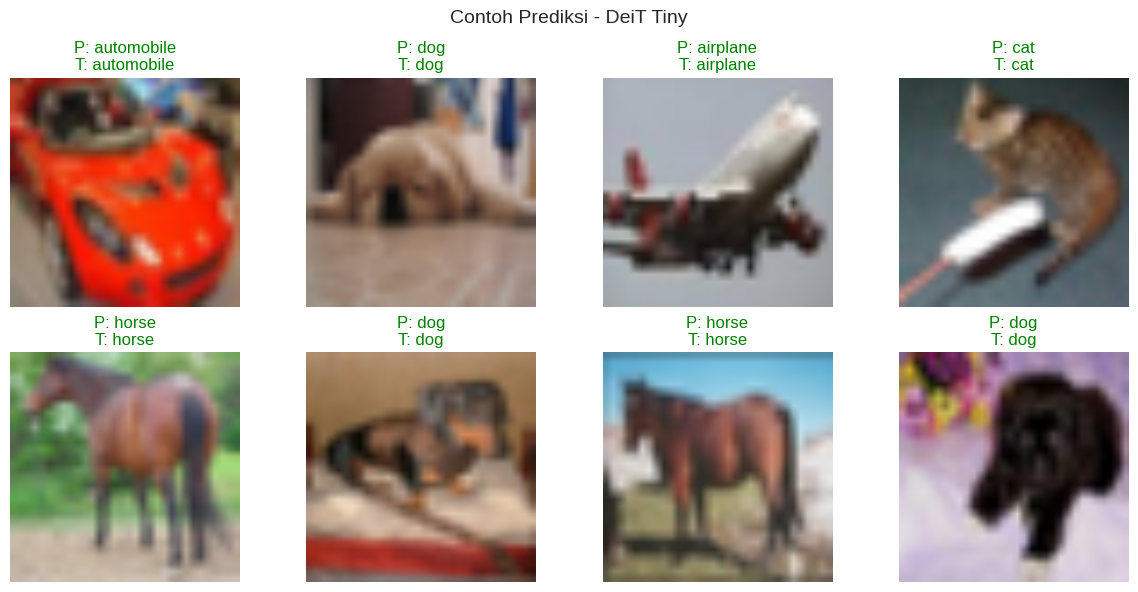

In [20]:
# Langkah 11b - Visualisasi contoh hasil prediksi dari setiap model
def show_sample_predictions(model_alias: str, num_images: int = 8, dataset=test_dataset) -> None:
    if model_alias not in experiment_results:
        raise ValueError(f'Model {model_alias} belum tersedia di experiment_results.')
    preds = experiment_results[model_alias]["evaluation"]["y_pred"]
    truths = experiment_results[model_alias]["evaluation"]["y_true"]
    if len(truths) == 0:
        print('Belum ada hasil evaluasi untuk model ini.')
        return
    num_images = min(num_images, len(truths))
    indices = random.sample(range(len(truths)), num_images)
    mean_tensor = torch.tensor(mean).view(3, 1, 1)
    std_tensor = torch.tensor(std).view(3, 1, 1)
    cols = min(4, num_images)
    rows = math.ceil(num_images / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.array(axes).reshape(rows, cols)
    for ax, idx in zip(axes.flatten(), indices):
        if idx >= len(dataset):
            ax.axis('off')
            continue
        img, _ = dataset[idx]
        img = (img * std_tensor + mean_tensor).clamp(0, 1)
        ax.imshow(img.permute(1, 2, 0))
        pred_label = CLASS_NAMES[preds[idx]]
        true_label = CLASS_NAMES[truths[idx]]
        color = 'green' if pred_label == true_label else 'red'
        ax.set_title(f'P: {pred_label}\nT: {true_label}', color=color)
        ax.axis('off')
    for ax in axes.flatten()[len(indices):]:
        ax.axis('off')
    plt.suptitle(f'Contoh Prediksi - {model_alias}', fontsize=14)
    plt.tight_layout()
    plt.show()

for alias in experiment_results.keys():
    print(f'Contoh prediksi untuk {alias}')
    show_sample_predictions(alias, num_images=8)


## 12. Tabel Ringkasan Komparasi


In [22]:
# Langkah 12 - Susun tabel ringkasan terpisah (parameter, metrik, inferensi)
param_rows = []
metric_rows = []
inference_rows = []
for alias, result in experiment_results.items():
    profile = result["profile"]
    eval_metrics = result["evaluation"]
    inference_metrics = result["inference"]
    param_rows.append({
        "Model": alias,
        "Backbone": result["model_name"],
        "Total Params (M)": round(profile["total_params"] / 1e6, 2),
        "Trainable Params (M)": round(profile["trainable_params"] / 1e6, 2),
        "Non-trainable Params (M)": round(profile["non_trainable_params"] / 1e6, 3),
        "Model Size (MB)": profile["model_size_mb"],
    })
    metric_rows.append({
        "Model": alias,
        "Test Accuracy": round(eval_metrics["overall_accuracy"], 4),
        "Macro Precision": round(eval_metrics["macro_precision"], 4),
        "Macro Recall": round(eval_metrics["macro_recall"], 4),
        "Macro F1": round(eval_metrics["macro_f1"], 4),
    })
    inference_rows.append({
        "Model": alias,
        "Avg Inference (ms/img)": round(inference_metrics["mean_ms_per_image"], 2),
        "Std Inference (ms/img)": round(inference_metrics["std_ms_per_image"], 2),
        "Throughput (img/s)": round(inference_metrics["throughput_img_per_s"], 2),
        "Est. Test Time (s)": round(inference_metrics["estimated_test_time_s"], 2),
        "Images Measured": inference_metrics["images_measured"],
        "Warmup Batches": inference_metrics["warmup_batches"],
    })

param_df = pd.DataFrame(param_rows)
metric_df = pd.DataFrame(metric_rows)
inference_df = pd.DataFrame(inference_rows)

print("=== Tabel Perbandingan Jumlah Parameter ===")
display(param_df)
print("=== Tabel Perbandingan Metrik Performa ===")
display(metric_df)
print("=== Tabel Perbandingan Waktu Inferensi ===")
display(inference_df)

print("Hardware yang digunakan:")
display(pd.DataFrame([hardware_info]))



=== Tabel Perbandingan Jumlah Parameter ===


,Model,Backbone,Total Params (M),Trainable Params (M),Non-trainable Params (M),Model Size (MB)
0,Swin Transformer (Tiny),swin_tiny_patch4_window7_224,27.53,27.53,0.0,105.01
1,DeiT Tiny,deit_tiny_patch16_224,5.53,5.53,0.0,21.08


=== Tabel Perbandingan Metrik Performa ===


,Model,Test Accuracy,Macro Precision,Macro Recall,Macro F1
0,Swin Transformer (Tiny),0.9773,0.9773,0.9773,0.9773
1,DeiT Tiny,0.9598,0.9598,0.9598,0.9597


=== Tabel Perbandingan Waktu Inferensi ===


,Model,Avg Inference (ms/img),Std Inference (ms/img),Throughput (img/s),Est. Test Time (s),Images Measured,Warmup Batches
0,Swin Transformer (Tiny),4.51,0.05,221.55,45.14,512,5
1,DeiT Tiny,1.07,0.05,931.73,10.73,512,5


Hardware yang digunakan:


,device,cuda_name,cuda_total_mem_gb,cpu,num_cpu_cores,ram_gb
0,cuda,Tesla T4,14.74,x86_64,2,12.67


In [23]:
# Langkah 13 - Simpan bobot model terbaik dan hasil prediksi
from pathlib import Path
save_dir = Path("artifacts")
save_dir.mkdir(exist_ok=True)

for alias, result in experiment_results.items():
    # Simpan hasil prediksi
    pred_path = save_dir / f"{alias.replace(' ', '_').lower()}_predictions.csv"
    df = pd.DataFrame({
        "true_label": result["evaluation"]["y_true"],
        "pred_label": result["evaluation"]["y_pred"]
    })
    df.to_csv(pred_path, index=False)
    print(f"Prediksi tersimpan ke {pred_path}")

    # Simpan bobot model terbaik
    weight_path = save_dir / f"{alias.replace(' ', '_').lower()}_best.pth"
    torch.save(result["best_state"], weight_path)
    print(f"Bobot tersimpan ke {weight_path}")

Prediksi tersimpan ke artifacts/swin_transformer_(tiny)_predictions.csv
Bobot tersimpan ke artifacts/swin_transformer_(tiny)_best.pth
Prediksi tersimpan ke artifacts/deit_tiny_predictions.csv
Bobot tersimpan ke artifacts/deit_tiny_best.pth
